# Introduction
The company has developed a new webpage to increase the number of paying users for their product. They are conducting an AB test to see the results of this new page. 
- Two equally-sized groups are created as control and treatment groups, labeled A and B. 
- The treatment group (B) is presented with the new webpage while the control group (A) is presented with the old one, and the experiment is run. 

Data is collected for both groups, and then hypothesis testing is applied to determine if the difference is significant or not.

# Hypothesis

- **H0**: There is not statistically significant difference between the old page and new page
- **H1**: There is statistically significant difference between the old page and new page

- - H₀ (Null Hypothesis): The data (all metrics value of both the page) follows a normal distribution, equal variance, proceed with parametric tests (eg. t-test, dependent t-test), which assume normality.
- - H₁ (Alternative Hypothesis): The data does not follow a normal distribution or not equal variance. use a non-parametric test that does not assume normality.

- - If p-value < 0.05 = significant -> **non-parametric test** (mannwhitneyu test) ELSE not significant -> **parametric test** (t-test, ANOVA, linear regression)

<quotes> When to use ANOVA:

When comparing the means of three or more groups.
When you have one or more independent variables (factors) and want to see if they significantly affect the outcome.
When investigating potential interactions between multiple factors (in the case of two-way ANOVA).

**Post-hoc Tests** for ANOVA:

If ANOVA finds a significant difference among the groups, it doesn't tell you which groups are different. To find this out, you need to perform post-hoc tests (e.g., Tukey's HSD) to make pairwise comparisons between groups.
</quotes>

# Parametric tests
- **Non-parametric test** 
- - Mann-Whitney U test
- - Wilcoxon Signed-Rank test
- - Kruskal-Wallis H test
- - Friedman test
- - Spearman's Rank Correlation
- - Chi-Square test
<br><br>
- **Parametric test** 
- - t-test
- - Welch's t-test
- - ANOVA
- - Pearson Correlation
- - linear regression
<br><br>
- **Summary Table**

| Test Type                | Parametric Tests                          | Non-Parametric Tests                      |
|--------------------------|-------------------------------------------|-------------------------------------------|
| **Comparing Means**      | One-sample t-test                         | Wilcoxon Signed-Rank test                 |
|                          | Independent two-sample t-test             | Mann-Whitney U test                       |
|                          | Paired t-test                             | Wilcoxon Signed-Rank test                 |
|                          | One-way ANOVA                             | Kruskal-Wallis H test                     |
|                          | Two-way ANOVA                             | Friedman test                             |
| **Correlation**          | Pearson Correlation                       | Spearman's Rank Correlation               |
| **Regression**           | Linear Regression                         | -                                         |
| **Variance**             | Bartlett's Test, Levene's Test            | Fligner-Killeen Test                      |
| **Categorical Data**     | -                                         | Chi-Square Test                           |

# Normality Assumption
- **Checking** normality for statistical testing later
- - histogram
- - QQPlot
- - Shapiro-Wilk Test with p > 0.05 = normal distributed

- Data should follow normal distribution (symmetric, p > 0.05) for **parametric test**
- If not normal distributed (p < 0.05) -> **transformation / non-parametric test**

# Variance Homogeneity
- Making sure all the dependent variables has same variance for statistical testing later
- H0: Variances are homogeneous
- H1: Variances are not homogeneous

- **Checking**
- - Levene's Test: if p > 0.05 = Equal Variance
- - Residual Plots: if increase or decrease systematically = non-equal variance (heteroscedasticity)
- - Bartlett's Test: Sensitive to non-normality, not used to test while non-normalized, evaluate using **Chi-square test**
- - Fligner-Killeen Test: can used when non-normalized

- **If not equal variance**
- - Robust non-parametric test methods for non-equal variance: eg. Welch's t-test, GLM (Generalized Linear model)
- - Transformation: log etc.
- - Weighted least square (WLS)

- **If equal variance**
- - use parametric test

# Data Ingestion and Libaries Import

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sms
from scipy.stats import shapiro, levene, mannwhitneyu

import warnings
warnings.filterwarnings('ignore')

ab_df = pd.read_csv('./ecommerce_ab_testing_2022_dataset1/ab_data.csv')
countries_df = pd.read_csv('./ecommerce_ab_testing_2022_dataset1/countries.csv')

# EDA

In [33]:
ab_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294480 entries, 0 to 294479
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294480 non-null  int64 
 1   timestamp     294480 non-null  object
 2   group         294480 non-null  object
 3   landing_page  294480 non-null  object
 4   converted     294480 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [34]:
ab_df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,11:48.6,control,old_page,0
1,804228,01:45.2,control,old_page,0
2,661590,55:06.2,treatment,new_page,0
3,853541,28:03.1,treatment,new_page,0
4,864975,52:26.2,control,old_page,1


In [35]:
# Unique values for each attribute
ab_df.apply(lambda x: x.nunique())

user_id         290585
timestamp        35993
group                2
landing_page         2
converted            2
dtype: int64

In [36]:
# Check for missing values
ab_df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [37]:
ab_df.shape

(294480, 5)

In [38]:
# keep the first of each duplicates only
# ab_df.drop_duplicates(subset='user_id', keep='first', inplace=True)
ab_df.drop_duplicates(subset='user_id', keep=False, inplace=True)
ab_df.shape

(286690, 5)

In [39]:
# counting the number of users in each group
ab_df.groupby(['group', 'landing_page']).agg({'user_id': 'count'})

,,user_id
group,landing_page,
control,old_page,143293
treatment,new_page,143397


In [40]:
# counting the average conversion rate in each group
ab_df.groupby(['group', 'landing_page']).agg({'converted': 'mean'})

,,converted
group,landing_page,
control,old_page,0.120173
treatment,new_page,0.118726


In [41]:
# Percentage of new page and old page
ab_df['landing_page'].value_counts(normalize=True)

landing_page
new_page    0.500181
old_page    0.499819
Name: proportion, dtype: float64

In [42]:
# Percentage of control and treatment group
ab_df['group'].value_counts(normalize=True)

group
treatment    0.500181
control      0.499819
Name: proportion, dtype: float64

In [43]:
# Cross check for group and landing page types to see if got any mutual exclusivity
print(ab_df[(ab_df['group'] == 'treatment') & (ab_df['landing_page'] == 'old_page')].head())
print()
print(ab_df[(ab_df['group'] == 'treatment') & (ab_df['landing_page'] == 'new_page')].head())
print()
print(ab_df[(ab_df['group'] == 'control') & (ab_df['landing_page'] == 'old_page')].head())
print()
print(ab_df[(ab_df['group'] == 'control') & (ab_df['landing_page'] == 'new_page')].head())

Empty DataFrame
Columns: [user_id, timestamp, group, landing_page, converted]
Index: []

   user_id timestamp      group landing_page  converted
2   661590   55:06.2  treatment     new_page          0
3   853541   28:03.1  treatment     new_page          0
6   679687   26:46.9  treatment     new_page          1
8   817355   58:09.0  treatment     new_page          1
9   839785   11:06.6  treatment     new_page          1

   user_id timestamp    group landing_page  converted
0   851104   11:48.6  control     old_page          0
1   804228   01:45.2  control     old_page          0
4   864975   52:26.2  control     old_page          1
5   936923   20:49.1  control     old_page          0
7   719014   48:29.5  control     old_page          0

Empty DataFrame
Columns: [user_id, timestamp, group, landing_page, converted]
Index: []


# Normality Testing

Normality Assumption
- H0: The assumption of normal distribution is provided
- H1: The assumption of normal distribution is not provided

- If the p-value is less than 0.05, it is considered significant and a non-parametric test (mannwhitneyu test) will be used. Else a parametric test (t-test)

## Shapiro-Wilk Test

In [44]:
# ab_df.loc[ab_df['landing_page'] == 'old_page', 'converted']
teststat_old, p_value_old = shapiro(ab_df.loc[ab_df['landing_page'] == 'old_page']['converted'])
print(f'Old page conversion number teststat: {teststat_old}, p_value: {p_value_old}')

teststat_new, p_value_new = shapiro(ab_df.loc[ab_df['landing_page'] == 'new_page']['converted'])
print(f'New page conversion number teststat: {teststat_new}, p_value: {p_value_new}')

if p_value_old > 0.05 and p_value_new > 0.05:
    print('Null hypothesis is not rejected, data is normally distributed.')
    print('Both old and new page conversion numbers are normally distributed, use parametric tests')
else:
    print('Null hypothesis is rejected, data is not normally distributed.')
    if p_value_old < 0.05 and p_value_new < 0.05:
        print('Both old and new page conversion numbers are not normally distributed, use non-parametric tests') 
    elif p_value_old < 0.05:
        print('Old page conversion numbers are not normally distributed, use non-parametric tests')
    else:
        print('New page conversion numbers are not normally distributed, use non-parametric tests')

Old page conversion number teststat: 0.3792334794998169, p_value: 0.0
New page conversion number teststat: 0.37685757875442505, p_value: 0.0
Null hypothesis is rejected, data is not normally distributed.
Both old and new page conversion numbers are not normally distributed, use non-parametric tests


## Histogram

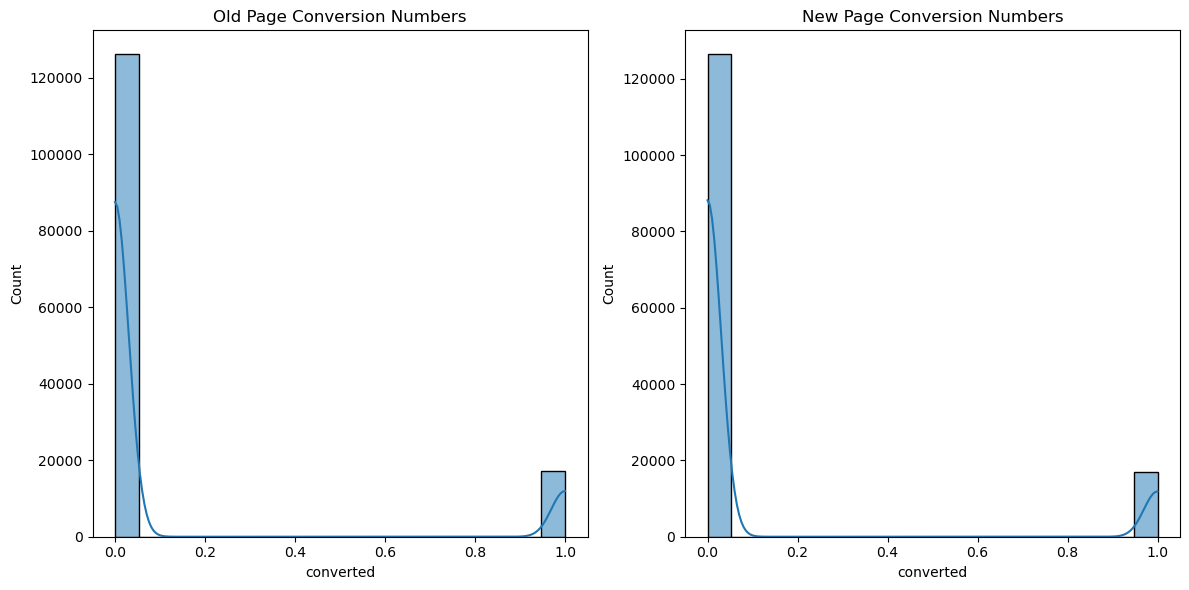

In [45]:
# Histogram of conversion numbers
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

sns.histplot(ab_df.loc[ab_df['landing_page'] == 'old_page']['converted'], kde=True, ax=ax[0])
ax[0].set_title('Old Page Conversion Numbers')

sns.histplot(ab_df.loc[ab_df['landing_page'] == 'new_page']['converted'], kde=True, ax=ax[1])
ax[1].set_title('New Page Conversion Numbers')

plt.tight_layout()
plt.show()

## QQPlot

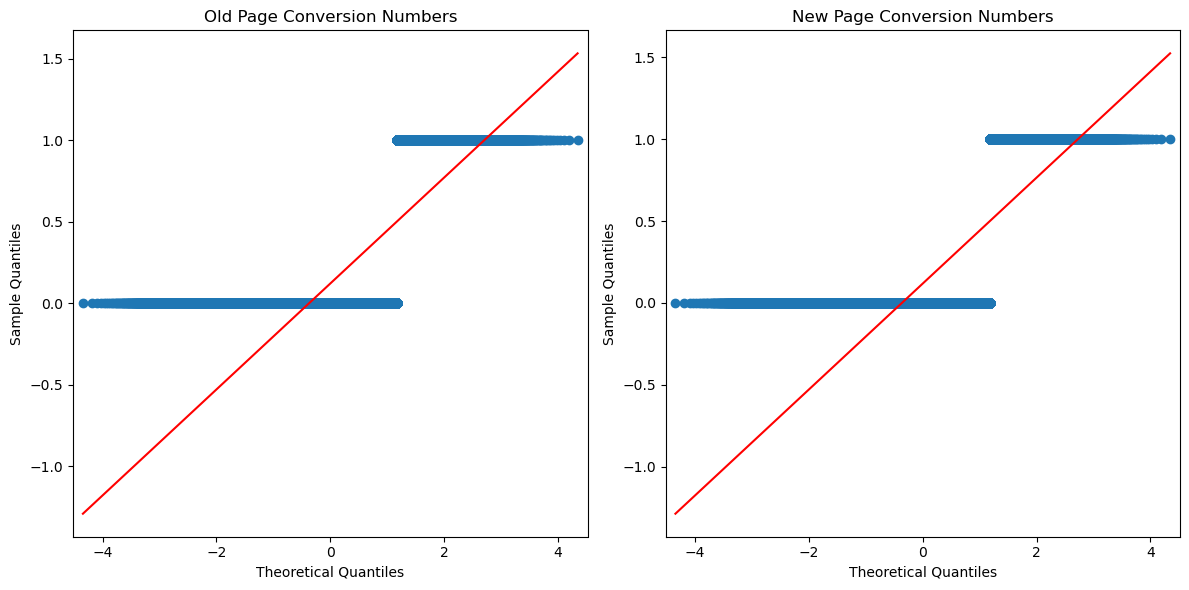

In [46]:
# QQ plot of conversion numbers
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

sms.qqplot(ab_df.loc[ab_df['landing_page'] == 'old_page']['converted'], line='s', ax=ax[0])
ax[0].set_title('Old Page Conversion Numbers')

sms.qqplot(ab_df.loc[ab_df['landing_page'] == 'new_page']['converted'], line='s', ax=ax[1])
ax[1].set_title('New Page Conversion Numbers')

plt.tight_layout()
plt.show()

- **Plot Points**:
- - The QQ plot displays the quantiles of your data against the quantiles of a standard normal distribution.
- - If the data is normally distributed, the points should fall approximately along a straight line.

- **Straight Line**:
- - Close to the Line: If the points lie close to the 45-degree reference line (the line of equality), it suggests that the data is approximately normally distributed.
- - Deviations from the Line: Significant deviations from the line indicate departures from normality.

- **Patterns of Deviation**:
- - S-shaped Curve: If the points form an S-shaped curve, it suggests that the data has heavier tails than a normal distribution (leptokurtic).
- - Inverted S-shaped Curve: If the points form an inverted S-shaped curve, it suggests that the data has lighter tails than a normal distribution (platykurtic).
- - Upward/Downward Curvature: If the points curve upwards or downwards, it suggests skewness in the data. Upward curvature indicates positive skewness, while downward curvature indicates negative skewness.

# Variance Homogeneity Testing
- H0: Variances are homogeneous
- H1: Variances are not homogeneous

## Levene's test

In [47]:
teststat, p_value = levene(ab_df.loc[ab_df['landing_page'] == 'old_page']['converted'],
                            ab_df.loc[ab_df['landing_page'] == 'new_page']['converted'])
print(f'Variance Homogeneuous of old page and new page teststat: {teststat}, p_value: {p_value}')

if p_value > 0.05:
    print('Null hypothesis is not rejected, Variance is homogeneuous')
    print('Both old and new page conversion numbers have equal variances, use parametric tests')
else:
    print('Null hypothesis is rejected, Variance is not homogeneuous')
    print('Old and new page conversion numbers do not have equal variances, use non-parametric tests')

Variance Homogeneuous of old page and new page teststat: 1.4267917566652295, p_value: 0.2322897281547632
Null hypothesis is not rejected, Variance is homogeneuous
Both old and new page conversion numbers have equal variances, use parametric tests


## Bartlett's Test
Data should be normalized, not used here

In [48]:
# # Example code
# from scipy.stats import bartlett

# stat, p_value = bartlett(ab_df.loc[ab_df['landing_page'] == 'old_page']['converted'],
#                                ab_df.loc[ab_df['landing_page'] == 'new_page']['converted'])
# print(f"Bartlett's Test: Chi-square statistic = {stat}, p-value = {p_value}")

## Fligner-Killeen Test
Data is not normalized, can be used

In [49]:
from scipy.stats import fligner

stat, p_value = fligner(ab_df.loc[ab_df['landing_page'] == 'old_page']['converted'],
                               ab_df.loc[ab_df['landing_page'] == 'new_page']['converted'])
print(f"Fligner-Killeen Test: Chi-square statistic = {stat}, p-value = {p_value}")

if p_value > 0.05:
    print('Null hypothesis is not rejected, Variance is homogeneuous')
    print('Both old and new page conversion numbers have equal variances, use parametric tests')
else:
    print('Null hypothesis is rejected, Variance is not homogeneuous')
    print('Old and new page conversion numbers do not have equal variances, use non-parametric tests')

Fligner-Killeen Test: Chi-square statistic = 1.426789632614739, p-value = 0.23228908748992913
Null hypothesis is not rejected, Variance is homogeneuous
Both old and new page conversion numbers have equal variances, use parametric tests


## Residual Plot

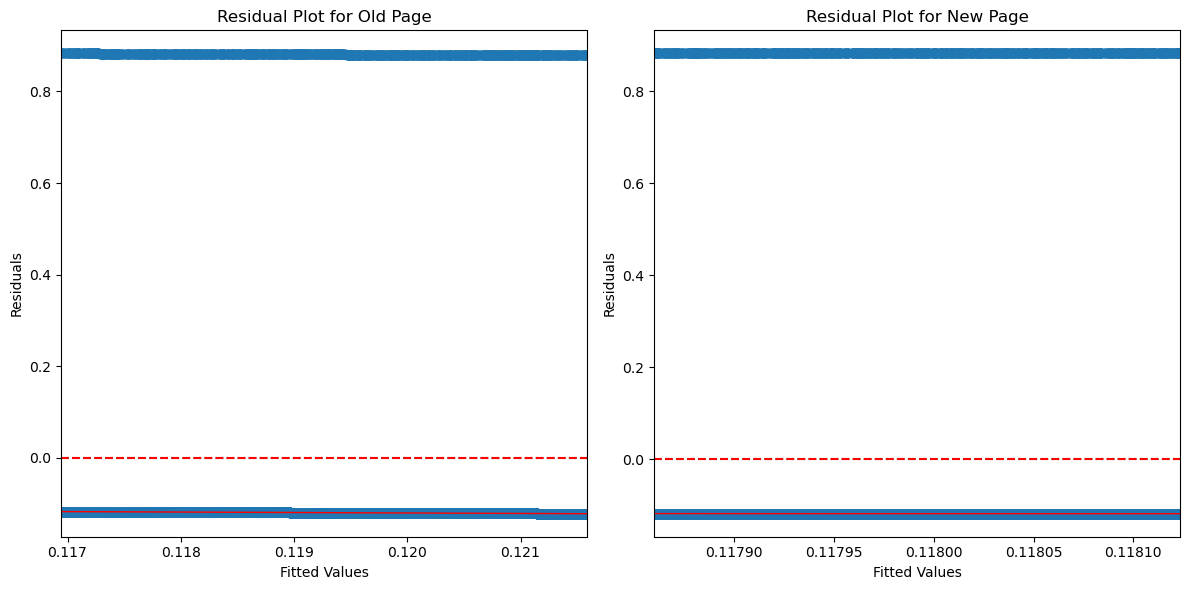

In [50]:
# Separate the data for old page and new page
old_page_data = ab_df.loc[ab_df['landing_page'] == 'old_page']['converted']
new_page_data = ab_df.loc[ab_df['landing_page'] == 'new_page']['converted']

# Downsampling the data as the data is too large
frac = 0.1
old_page_data = old_page_data.sample(frac=frac, random_state=64)
new_page_data = new_page_data.sample(frac=frac, random_state=64)

# Fit a linear regression model for old page
X_old = sms.add_constant(np.arange(len(old_page_data)))  # Adding index as a constant term
model_old = sms.OLS(old_page_data, X_old).fit() # Fit the Ordinary Least Squares (OLS) model
fitted_values_old = model_old.fittedvalues # Get the fitted values (predictions)
residuals_old = model_old.resid # Get the residuals (actual - predictions) (difference between actual and predicted values)

# Fit a linear regression model for new page
X_new = sms.add_constant(np.arange(len(new_page_data)))
model_new = sms.OLS(new_page_data, X_new).fit()
fitted_values_new = model_new.fittedvalues
residuals_new = model_new.resid

# Create residual plots
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Residual plot for old page
sns.residplot(x=fitted_values_old, y=residuals_old, lowess=True, ax=ax[0], line_kws={'color': 'red', 'lw': 1})
ax[0].axhline(y=0, color='r', linestyle='--')
ax[0].set_title('Residual Plot for Old Page')
ax[0].set_xlabel('Fitted Values')
ax[0].set_ylabel('Residuals')

# Residual plot for new page
sns.residplot(x=fitted_values_new, y=residuals_new, lowess=True, ax=ax[1], line_kws={'color': 'red', 'lw': 1})
ax[1].axhline(y=0, color='r', linestyle='--')
ax[1].set_title('Residual Plot for New Page')
ax[1].set_xlabel('Fitted Values')
ax[1].set_ylabel('Residuals')

plt.tight_layout()
plt.show()

**Blue Points**:
- represent the residuals (the differences between the actual values and the predicted values) plotted against the fitted values.
- Each blue point corresponds to a single observation in your dataset.

**Blue Points with Red Line**:
- The red line is a LOWESS (Locally Weighted Scatterplot Smoothing) line, which is a smoothed line that helps to visualize the trend in the residuals.
- The blue points with the red line indicate the smoothed trend of the residuals.

**How to Assess Equal Variance (Homoscedasticity)**

- Random Scatter:
If the blue points (residuals) are randomly scattered around the horizontal red line (y=0) without any clear pattern, it suggests that the variances are equal (homoscedasticity).

- Patterned Residuals:
If the blue points show a pattern (e.g., funnel shape, increasing or decreasing spread), it suggests that the variances are not equal (heteroscedasticity).

**Horizontal Red Line** (y=0):
- To see if the residuals are centered around zero, indicating that the model's predictions are unbiased.

The red line below in the graph is **Lowess Smoothing Line**

- This line helps to identify any patterns or systematic deviations in the residuals. If the LOWESS line is approximately horizontal and close to the zero line, it suggests homoscedasticity (equal variances)

- If the LOWESS line shows a pattern (e.g., a curve or slope), it suggests heteroscedasticity (unequal variances).

Both Lowess lines are almost horizontal, which indicates that the residuals are homoscedastic
- Hence, the residuals are homoscedastic
- Hence, the variance is homogeneuous

# Hypothesis Testing

- H0: There is not statistically significant difference between the old page and new page
- H1: There is statistically significant difference between the old page and new page
<br><br>
- Normality: Null hypothesis rejected
- Variance Homogeneity: Null hypothesis accepted

Since normality and homoscedasticity are not both satisfied at the same time, we will use non-parametric tests

## Mann-Whitney U test

In [51]:
# Mann-Whitney U test
teststat, p_value = mannwhitneyu(ab_df.loc[ab_df['landing_page'] == 'old_page']['converted'],
                            ab_df.loc[ab_df['landing_page'] == 'new_page']['converted'])
print(f'Mann-Whitney U teststat: {teststat}, p_value: {p_value}')

if p_value > 0.05:
    print('Null hypothesis is not rejected, both old and new page conversion numbers are equal')
    print('There is no significant difference between old and new page conversion numbers, the change does not bring significant improvement')
else:
    print('Null hypothesis is rejected, both old and new page conversion numbers are not equal')
    print('There is a significant difference between old and new page conversion numbers, the change brings significant improvement')

Mann-Whitney U teststat: 10288759668.0, p_value: 0.23228910319572493
Null hypothesis is not rejected, both old and new page conversion numbers are equal
There is no significant difference between old and new page conversion numbers, the change does not bring significant improvement


## Wilcoxon signed-rank test

In [62]:
# Wilcoxon signed-rank test
from scipy.stats import wilcoxon

# Separate the data for old page and new page
old_page_data = ab_df.loc[ab_df['landing_page'] == 'old_page']['converted']
new_page_data = ab_df.loc[ab_df['landing_page'] == 'new_page']['converted']

# Ensure the samples have the same length by taking a random sample of the smaller size
min_length = min(len(old_page_data), len(new_page_data))
old_page_sample = old_page_data.sample(n=min_length, random_state=1)
new_page_sample = new_page_data.sample(n=min_length, random_state=1)

# Wilcoxon signed-rank test
teststat, p_value = wilcoxon(old_page_sample, new_page_sample)
print(f'Wilcoxon signed-rank teststat: {teststat}, p_value: {p_value}')

# Interpret the results
if p_value < 0.05:
    if teststat > 0:
        print("There is a statistically significant positive difference between the old page and new page conversion rates.")
    elif teststat < 0:
        print("There is a statistically significant negative difference between the old page and new page conversion rates.")
    else:
        print("There is no difference between the old page and new page conversion rates.")
else:
    print("There is no statistically significant difference between the old page and new page conversion rates.")

Wilcoxon signed-rank teststat: 225958320.0, p_value: 0.2333387042131262
There is no statistically significant difference between the old page and new page conversion rates.


## Kruskal-Wallis H test

In [61]:
from scipy.stats import kruskal

# Separate the data for old page and new page
old_page_data = ab_df.loc[ab_df['landing_page'] == 'old_page']['converted']
new_page_data = ab_df.loc[ab_df['landing_page'] == 'new_page']['converted']

# Kruskal-Wallis H test
h_stat, p_value = kruskal(old_page_data, new_page_data)
print(f'Kruskal-Wallis H teststat: {h_stat}, p_value: {p_value}')

# Interpret the results
if p_value < 0.05:
    print("There is a statistically significant difference between the old page and new page conversion rates.")
else:
    print("There is no statistically significant difference between the old page and new page conversion rates.")

Kruskal-Wallis H teststat: 1.4267896325324378, p_value: 0.23228908750339744
There is no statistically significant difference between the old page and new page conversion rates.


## Friedman test

The Friedman test is used to compare the distributions of three or more related groups. It is particularly useful when you have repeated measures or matched groups. If you only have two groups, you should use the Wilcoxon signed-rank test instead.

## Spearman's Rank Correlation

In [59]:
import pandas as pd
from scipy.stats import spearmanr

# Separate the data for old page and new page
old_page_data = ab_df.loc[ab_df['landing_page'] == 'old_page']['converted']
new_page_data = ab_df.loc[ab_df['landing_page'] == 'new_page']['converted']

# Ensure the samples have the same length by taking a random sample of the smaller size
min_length = min(len(old_page_data), len(new_page_data))
old_page_sample = old_page_data.sample(n=min_length, random_state=1)
new_page_sample = new_page_data.sample(n=min_length, random_state=1)

# Calculate Spearman's Rank Correlation
corr, p_value = spearmanr(old_page_sample, new_page_sample)

# Print the correlation coefficient and p-value
print(f"Spearman's Rank Correlation: {corr}, p-value: {p_value}")

# Interpret the results
if p_value < 0.05:
    if corr > 0:
        print("There is a statistically significant positive correlation between the old page and new page conversion rates.")
    elif corr < 0:
        print("There is a statistically significant negative correlation between the old page and new page conversion rates.")
    else:
        print("There is no correlation between the old page and new page conversion rates.")
else:
    print("There is no statistically significant correlation between the old page and new page conversion rates.")

Spearman's Rank Correlation: -0.0007636346059376669, p-value: 0.7725322208533001
There is no statistically significant correlation between the old page and new page conversion rates.


# Conclusion

There is no statistically significant correlation between the old page and new page conversion rates.